# Common Envelope implementation comparison

In here we will compare the output of two simulations, one using the implementation of [Marchant et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021arXiv210309243M/abstract) while the other follows [García et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021arXiv210303161G/abstract).

Briefly, both subroutines uses the energy formalism in which the envelope is ejected thanks to the release of orbital energy. Additionally, both take into consideration the recombination energy of H and He. The difference lies in how the orbital angular momentum is computed.

In [1]:
# Load config, modules and MESA output

## avoid restarting kernel
%load_ext autoreload
%autoreload 2

# Libraries used
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator

from mesa_reader import MesaInfo

## Set some global options
warnings.filterwarnings('ignore')
plt.style.use('style.mpl')
np.seterr(all='ignore');

def find_zams(logl, loglh, model):
    for m in model:
        if logl.iloc[int(m)] > 0.998 * loglh.iloc[int(m)]:
            return int(m)

def find_tams(center_h1, model):
    for m in model:
        if center_h1.iloc[int(m)] < 1e-5:
            return int(m)

def group_consecutives(vals, step=1):
    '''Return list of consecutive lists of numbers from vals (number list).'''
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

## Binary systems

The binaries under study consists of a donor star (M$_{\rm donor}$) ith a NS ($M_{\rm NS}$) or a BH ($M_{\rm BH}$) orbiting around in a circular orbit.

The first binary contains a 20 M$_\odot$ star and 1.4 M$_\odot$ NS with an orbital period ($P_{\rm orb}$) of 2239 days. This binary is chosen to have well-developed convective envelope when the mass-transfer phase starts.

The second one contains a 30 M$_\odot$ star and a 5 M$_\odot$ BH with $P_{\rm orb}$ of 2238 days. This binary is chosen from the sample presented in Marchant et al paper.

In [2]:
# Load MESA output

## Marchant implementation
p20_marchant = MesaInfo('../data/marchant/history_m20.00_q0.07_p2239.66.data')
p30_marchant = MesaInfo('../data/marchant/history_m30.00_q0.17_p2238.72.data')
b20_marchant = MesaInfo('../data/marchant/binary_history_xrb_m20.00_q0.07_p2239.66.data')
b30_marchant = MesaInfo('../data/marchant/binary_history_xrb_m30.00_q0.17_p2238.72.data')

## FGASB one
p20_fgasb = MesaInfo('../data/fgasb/history_m20.00_q0.07_p2239.66.data')
p30_fgasb = MesaInfo('../data/fgasb/history_m30.00_q0.17_p2238.72.data')
b20_fgasb = MesaInfo('../data/fgasb/binary_history_xrb_m20.00_q0.07_p2239.66.data')
b30_fgasb = MesaInfo('../data/fgasb/binary_history_xrb_m30.00_q0.17_p2238.72.data')

We start by showing a comparison of both implementations

### HR diagram

In [3]:
def add_radii_lines(fig, ax):
    x = np.linspace(0, 8, 100)
    for r in (0.01, 0.1, 1, 10, 100, 1000, 10000):
        y = 4*x + 2*np.log10(r) - 15.04680947
        ax.plot(x, y, linestyle=':', color='grey', alpha=0.6, zorder=-99)
    ax.text(5.00, ax.get_ylim()[0]+0.02, '$1 \\; R_\\odot$', color='grey')
    ax.text(4.50, ax.get_ylim()[0]+0.02, '$10 \\; R_\\odot$', color='grey')
    ax.text(4.00, ax.get_ylim()[0]+0.02, '$100 \\; R_\\odot$', color='grey')
    ax.text(3.50, ax.get_ylim()[0]+0.02, '$1000 \\; R_\\odot$', color='grey')
    return fig, ax

def plot_hr(lgT, lgL, ce, mods, fig, ax, color):
    mask = ce < 1
    model_numbers = group_consecutives(mods[mask])
    lgT = lgT[30:]
    lgL = lgL[30:]
    for i in range(len(model_numbers)):
        tmp = [int(m) for m in model_numbers[i]]
        ax.plot(lgT[tmp[:-31]], lgL[tmp[:-31]], color=color, zorder=-99)
    ax.scatter(lgT[-1], lgL[-1], s=60, marker='*', edgecolor='black', facecolor='yellow', zorder=99)
    return fig, ax

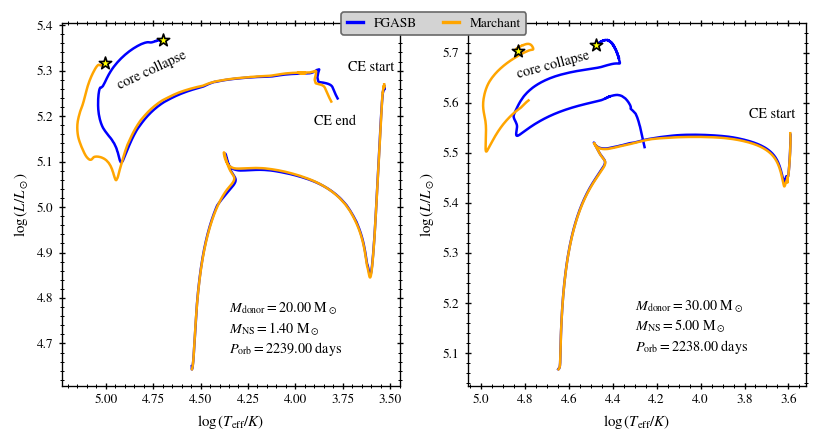

In [4]:
plt.style.use('style.mpl')
fig, axs = plt.subplots(figsize=(8.0,4.0), ncols=2)
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlabel('$\\log\,(T_{\\rm eff}/K)$')
    ax.set_ylabel('$\\log\,(L/L_\\odot)$')

# m1 = 20, m2 = 1.4
plot_hr(p20_fgasb.data.log_Teff, p20_fgasb.data.log_L, b20_fgasb.data.ce_phase,
        p20_fgasb.data.model_number, fig, axs[0], 'blue')
plot_hr(p20_marchant.data.log_Teff, p20_marchant.data.log_L, b20_marchant.data.CE_flag,
        p20_marchant.data.model_number, fig, axs[0], 'orange')

axs[0].annotate('CE start', xy=(3.72, 5.30))
axs[0].annotate('CE end', xy=(3.90, 5.18))
axs[0].annotate('core collapse', xy=(4.95, 5.26), rotation=25)

msg = '$M_{} = {:.2f}$ M$_\\odot$\n'.format('{\\rm donor}', 20)
msg += '$M_{} = {:.2f}$ M$_\\odot$\n'.format('{\\rm NS}', 1.4)
msg += '$P_{} = {:.2f}$ days\n'.format('{\\rm orb}', 2239)
axs[0].annotate(msg, xy=(4.35, 4.64))

# m1 = 30, m2 = 5
plot_hr(p30_fgasb.data.log_Teff, p30_fgasb.data.log_L, b30_fgasb.data.ce_phase,
        p30_fgasb.data.model_number, fig, axs[1], 'blue')
plot_hr(p30_marchant.data.log_Teff, p30_marchant.data.log_L, b30_marchant.data.CE_flag,
        p30_marchant.data.model_number, fig, axs[1], 'orange')

axs[1].annotate('CE start', xy=(3.78, 5.57))
axs[1].annotate('core collapse', xy=(4.84, 5.65), rotation=15)

msg = '$M_{} = {:.2f}$ M$_\\odot$\n'.format('{\\rm donor}', 30)
msg += '$M_{} = {:.2f}$ M$_\\odot$\n'.format('{\\rm NS}', 5)
msg += '$P_{} = {:.2f}$ days\n'.format('{\\rm orb}', 2238)
axs[1].annotate(msg, xy=(4.30, 5.07))

# label
f = lambda c: plt.plot([], [], color=c, lw=2, ls='-')[0]
fig.legend([f('blue'), f('orange')], ['FGASB', 'Marchant'],
          handlelength=1.2, ncol=2,
          fancybox=True, frameon=True, facecolor='lightgray', edgecolor='dimgray', framealpha=1.0,
          loc='center', bbox_to_anchor=(-0.1,1.0), bbox_transform=ax.transAxes);

### Common Envelope phase evolution

Here we show parameters during the CE phase: orbital period, masses, orbital angular momentum

In [5]:
def plot_ce_info(age, Porb, R, RL, M, ce, fig, axs, color):
    mask = ce > 0
    t0 = age[mask][0]
    axs[0].plot(age[mask]-t0, Porb[mask], color=color, zorder=99)
    axs[1].plot(age[mask]-t0, R[mask], color=color, zorder=99)
    axs[1].plot(age[mask]-t0, RL[mask], color=color, ls=':', zorder=99)
    axs[2].plot(age[mask]-t0, M[mask], color=color, zorder=99)
    return fig, ax

def add_labels(fig, axs):
    axs[0][0].set_ylabel('$P_{\\rm orb}$ [d]')
    axs[1][0].set_ylabel('$R$, $R_{\\rm RL}$ [R$_\\odot$]')
    axs[2][0].set_ylabel('mass [M$_\\odot$]')
    axs[-1][0].set_xlabel('$\\tau_{\\rm CE}$ [yr]')
    axs[-1][1].set_xlabel('$\\tau_{\\rm CE}$ [yr]')

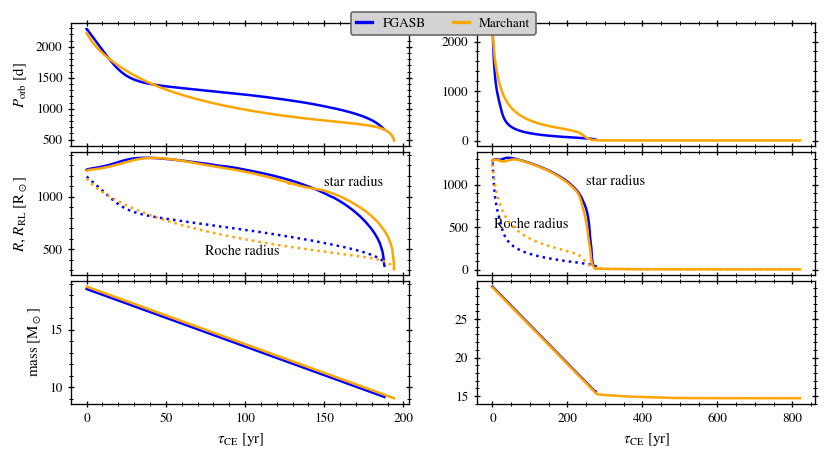

In [6]:
plt.style.use('style.mpl')
fig, axs = plt.subplots(figsize=(8.0,4.2), nrows=3, ncols=2, sharex='col')
plt.subplots_adjust(hspace=0.05, wspace=0.2)
add_labels(fig, axs)

# m1 = 20, m2 = 1.4
plot_ce_info(b20_fgasb.data.age, b20_fgasb.data.period_days, b20_fgasb.data.star_1_radius,
             b20_fgasb.data.rl_1, b20_fgasb.data.star_1_mass, b20_fgasb.data.ce_phase,
             fig, [axs[0][0], axs[1][0], axs[2][0]], 'blue')
plot_ce_info(b20_marchant.data.age, b20_marchant.data.period_days, p20_marchant.data.photosphere_r,
             b20_marchant.data.rl_1, b20_marchant.data.star_1_mass, b20_marchant.data.CE_flag,
             fig, [axs[0][0], axs[1][0], axs[2][0]], 'orange')

# m1 = 30, m2 = 5
plot_ce_info(b30_fgasb.data.age, b30_fgasb.data.period_days, b30_fgasb.data.star_1_radius,
             b30_fgasb.data.rl_1, b30_fgasb.data.star_1_mass, b30_fgasb.data.ce_phase,
             fig, [axs[0][1], axs[1][1], axs[2][1]], 'blue')
plot_ce_info(b30_marchant.data.age, b30_marchant.data.period_days, p30_marchant.data.photosphere_r,
             b30_marchant.data.rl_1, b30_marchant.data.star_1_mass, b30_marchant.data.CE_flag,
             fig, [axs[0][1], axs[1][1], axs[2][1]], 'orange')

axs[1][0].annotate('star radius', xy=(150, 1100))
axs[1][0].annotate('Roche radius', xy=(75, 450))
axs[1][1].annotate('star radius', xy=(250, 1000))
axs[1][1].annotate('Roche radius', xy=(5, 500))

# label
f = lambda c: plt.plot([], [], color=c, lw=2, ls='-')[0]
fig.legend([f('blue'), f('orange')], ['FGASB', 'Marchant'],
          handlelength=1.2, ncol=2,
          fancybox=True, frameon=True, facecolor='lightgray', edgecolor='dimgray', framealpha=1.0,
          loc='center', bbox_to_anchor=(-0.1,1.0), bbox_transform=axs[0][1].transAxes);

### Final binary configuration

Check similarities and differences between the configuration of the binary system at the end of its evolution (end of core C burning)

In [7]:
def plot_final_info(M, Mcore, Porb, M_marchant, Mcore_marchant, Porb_marchant, fig, ax):
    ax.scatter(1, 100 * abs(M[-1] - M_marchant[-1]) / M[-1], s=20, c='black', marker='s', zorder=99)
    ax.scatter(2, 100 * abs(Mcore[-1] - Mcore_marchant[-1]) / Mcore[-1], s=20, c='black', marker='s', zorder=99)
    ax.scatter(3, 100 * abs(Porb[-1] - Porb_marchant[-1]) / Porb[-1], s=20, c='black', marker='s', zorder=99)
    return fig, ax

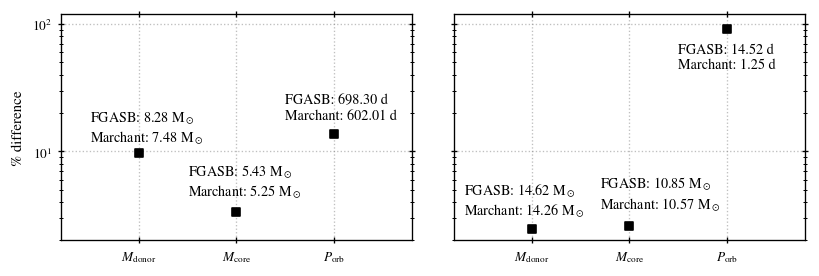

In [8]:
plt.style.use('style.mpl')
fig, axs = plt.subplots(figsize=(8.0,2.5), ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.12)
axs[0].set_ylabel('% difference')
for ax in axs:
    ax.set_xticks([1, 2, 3], minor=False)
    ax.set_xticklabels(['$M_{\\rm donor}$', '$M_{\\rm core}$', '$P_{\\rm orb}$'], minor=False)
    ax.set_xlim(left=0.2, right=3.8)
    ax.xaxis.set_minor_locator(FixedLocator([]))
    ax.set_yscale('log')
    ax.set_ylim(bottom=2, top=120)
    ax.grid(ls=':', color='gray', alpha=0.5, zorder=-99)

plot_final_info(p20_fgasb.data.star_mass, p20_fgasb.data.c_core_mass, b20_fgasb.data.period_days,
                p20_marchant.data.star_mass, p20_marchant.data.c_core_mass, b20_marchant.data.period_days,
                fig, axs[0])

msg = 'FGASB: {:.2f} M$_\\odot$\n'.format(p20_fgasb.data.star_mass[-1])
msg += 'Marchant: {:.2f} M$_\\odot$'.format(p20_marchant.data.star_mass[-1])
axs[0].annotate(msg, xy=(0.5,12))

msg = 'FGASB: {:.2f} M$_\\odot$\n'.format(p20_fgasb.data.c_core_mass[-1])
msg += 'Marchant: {:.2f} M$_\\odot$'.format(p20_marchant.data.c_core_mass[-1])
axs[0].annotate(msg, xy=(1.5,4.5))

msg = 'FGASB: {:.2f} d\n'.format(b20_fgasb.data.period_days[-1])
msg += 'Marchant: {:.2f} d'.format(b20_marchant.data.period_days[-1])
axs[0].annotate(msg, xy=(2.5, 18))

plot_final_info(p30_fgasb.data.star_mass, p30_fgasb.data.c_core_mass, b30_fgasb.data.period_days,
                p30_marchant.data.star_mass, p30_marchant.data.c_core_mass, b30_marchant.data.period_days,
                fig, axs[1])

msg = 'FGASB: {:.2f} M$_\\odot$\n'.format(p30_fgasb.data.star_mass[-1])
msg += 'Marchant: {:.2f} M$_\\odot$'.format(p30_marchant.data.star_mass[-1])
axs[1].annotate(msg, xy=(0.3,3.2))

msg = 'FGASB: {:.2f} M$_\\odot$\n'.format(p30_fgasb.data.c_core_mass[-1])
msg += 'Marchant: {:.2f} M$_\\odot$'.format(p30_marchant.data.c_core_mass[-1])
axs[1].annotate(msg, xy=(1.7,3.6))

msg = 'FGASB: {:.2f} d\n'.format(b30_fgasb.data.period_days[-1])
msg += 'Marchant: {:.2f} d'.format(b30_marchant.data.period_days[-1])
axs[1].annotate(msg, xy=(2.5, 45));

The most impactful difference comes from the final orbital period, which is directly connected to how the orbital angular momentum is computed in each implementation of the CE, as shown previously.